In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 15 - The SIMPLE model of memory

## 15.1 The SIMPLE model
Brown, Neath, and Chater (2007) proposed the SIMPLE (Scale-Invariant Memory, Perception, and LEarning) model, which, among various applications, has been applied to the basic memory phenomenon of free recall.

$$ c_x \sim \text{Uniform}(0,100)$$
$$ s_x \sim \text{Uniform}(0,100)$$
$$ t_x \sim \text{Uniform}(0,1) $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

In [2]:
y = pd.read_csv('data/k_M.txt', ',', header=None)
n = np.array([1440, 1280, 1520, 1520, 1200, 1280])
listlength = np.array([10, 15, 20, 20, 30, 40])
lagall = np.array([2, 2, 2, 1, 1, 1])
offset = np.array([15, 20, 25, 10, 15, 20])
dsets = 6
m = np.zeros(np.shape(y))
for i in range(dsets):
    m[i, 0:listlength[i]]=offset[i]+np.arange((listlength[i])*lagall[i], 0, -lagall[i])
pc = pd.read_csv('data/pc_M.txt', ',', header=None)
pcmat = np.asarray(pc).T

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,437.1:  18%|█▊        | 35491/200000 [01:23<06:17, 435.52it/s]
Convergence archived at 35500
Interrupted at 35,500 [17%]: Average Loss = 28,068
100%|██████████| 3500/3500.0 [29:09<00:00,  2.04it/s]


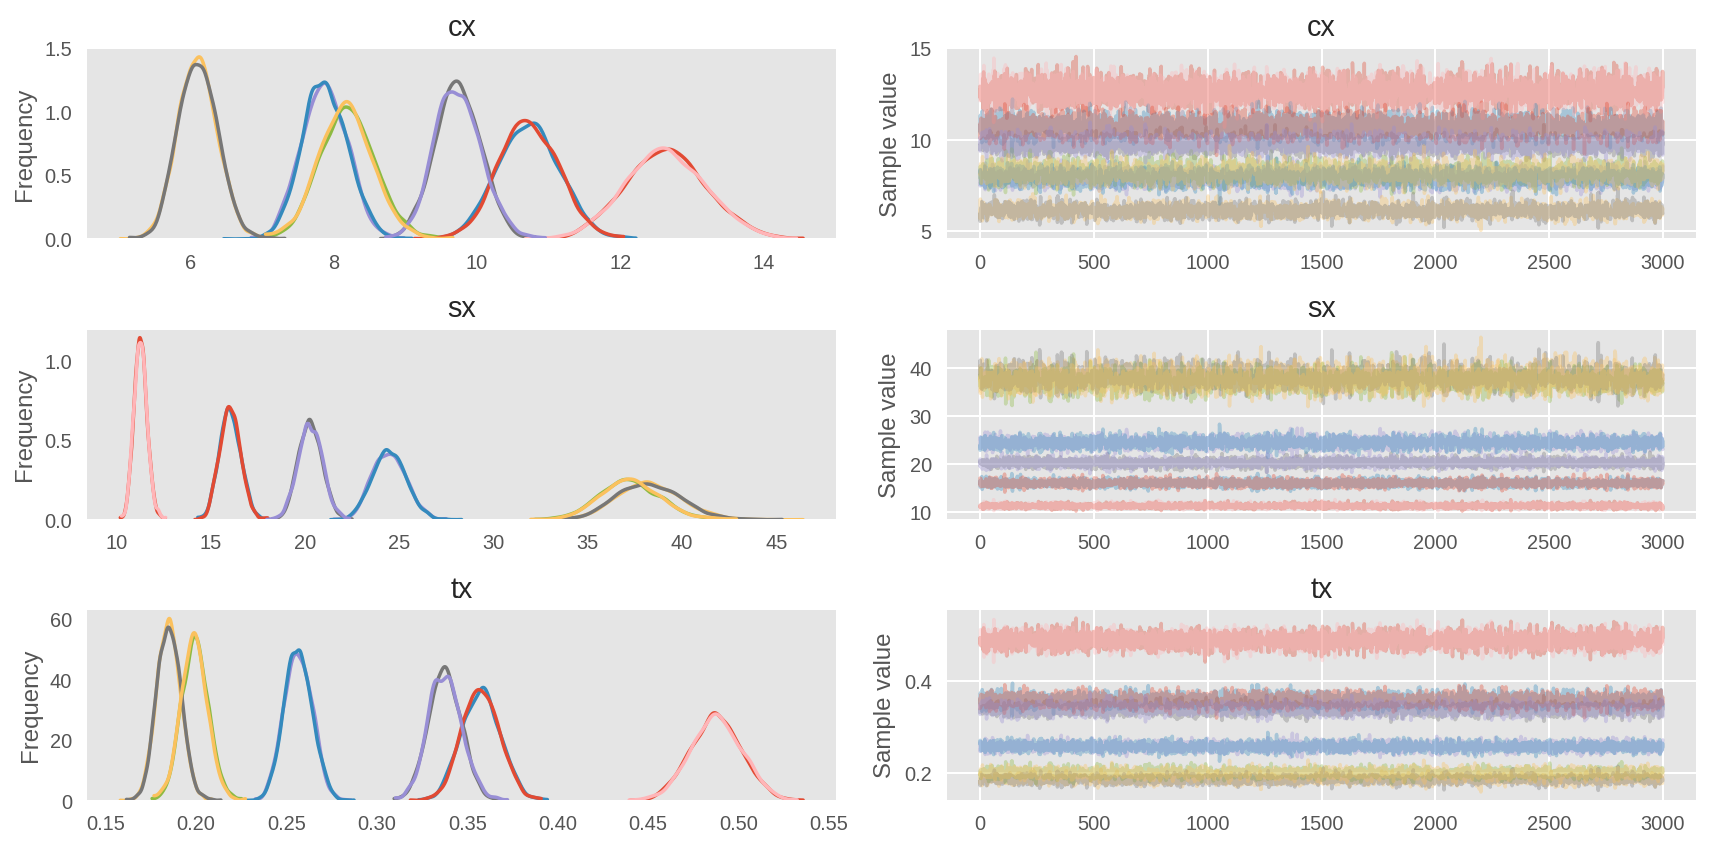

In [3]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2==0] = 1e-5 # to avoid NaN in ADVI
nmat = np.repeat(n[:,np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:,:,np.newaxis],nitem,axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat>0)

with pm.Model() as simple1:
    cx = pm.Uniform('cx', lower=0, upper=100, shape=dsets, testval=np.ones(dsets)*20)
    sx = pm.Uniform('sx', lower=0, upper=100, shape=dsets)
    tx = pm.Uniform('tx', lower=0, upper=1, shape=dsets)
    
    # Similarities
    eta = tt.exp(-cx[:,np.newaxis,np.newaxis]*abs(tt.log(mmat1)-tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2), nitem), (dsets, nitem, nitem))
    
    # Discriminabilities
    disc = eta/etasum
    
    # Response Probabilities
    resp = 1/(1+tt.exp(-sx[:,np.newaxis,np.newaxis]*(disc-tx[:,np.newaxis,np.newaxis])))
    
    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta=1-tt.prod(1-resp, axis=2)
    
    yobs = pm.Binomial('yobs', p=theta[mask], n=nmat[mask], observed=ymat[mask])
    trace = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace, varnames=['cx', 'sx', 'tx']);

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 2,219.3:  15%|█▍        | 29908/200000 [00:30<02:55, 967.08it/s]   
Convergence archived at 30000
Interrupted at 30,000 [15%]: Average Loss = 69,736
100%|██████████| 3500/3500.0 [09:40<00:00,  5.34it/s]


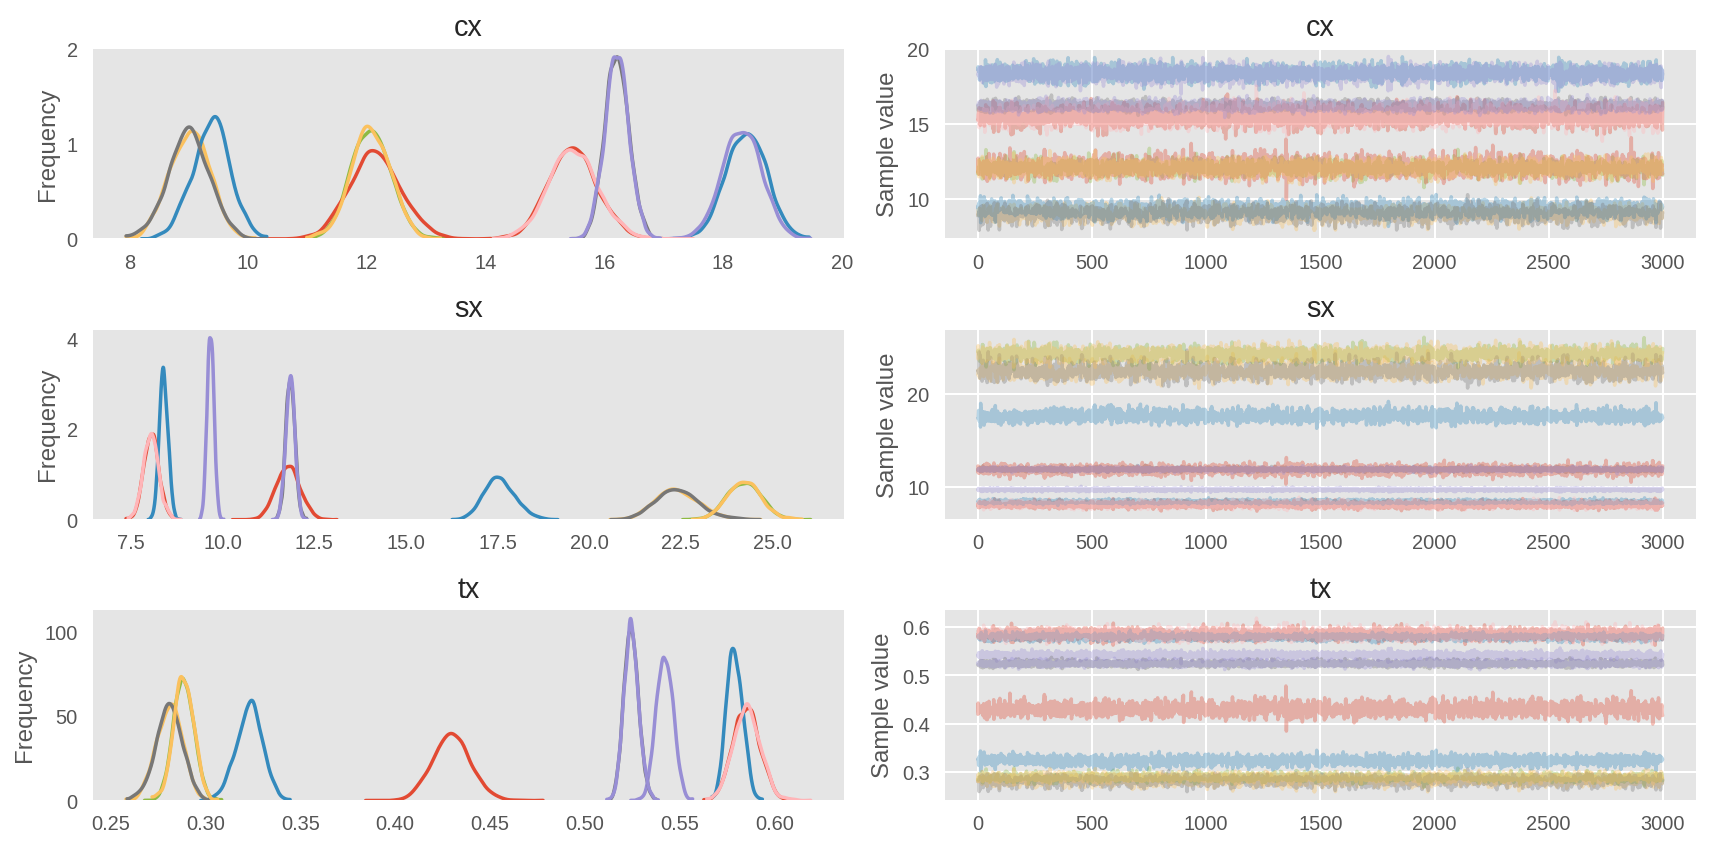

In [4]:
ymat = np.asarray(y).T
mmat = m.T

with pm.Model() as simple1:
    cx = pm.Uniform('cx', lower=0, upper=100, shape=dsets, testval=np.ones(dsets)*20)
    sx = pm.Uniform('sx', lower=0, upper=100, shape=dsets)
    tx = pm.Uniform('tx', lower=0, upper=1, shape=dsets)
    
    yobs=[]
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x], ]*sz).T
        m2 = np.array([mmat[0:sz, x], ]*sz)

        eta = tt.exp(-cx[x]*abs(tt.log(m1)-tt.log(m2)))
        etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+tt.exp(-sx[x]*(disc-tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, .999)
        # theta=1-tt.prod(1-resp,axis=1)
        
        yobs.append([pm.Binomial("yobs_%x"%x, p=theta, n=n[x], observed=ymat[0:sz, x])])
        
    trace = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace, varnames=['cx', 'sx', 'tx']);

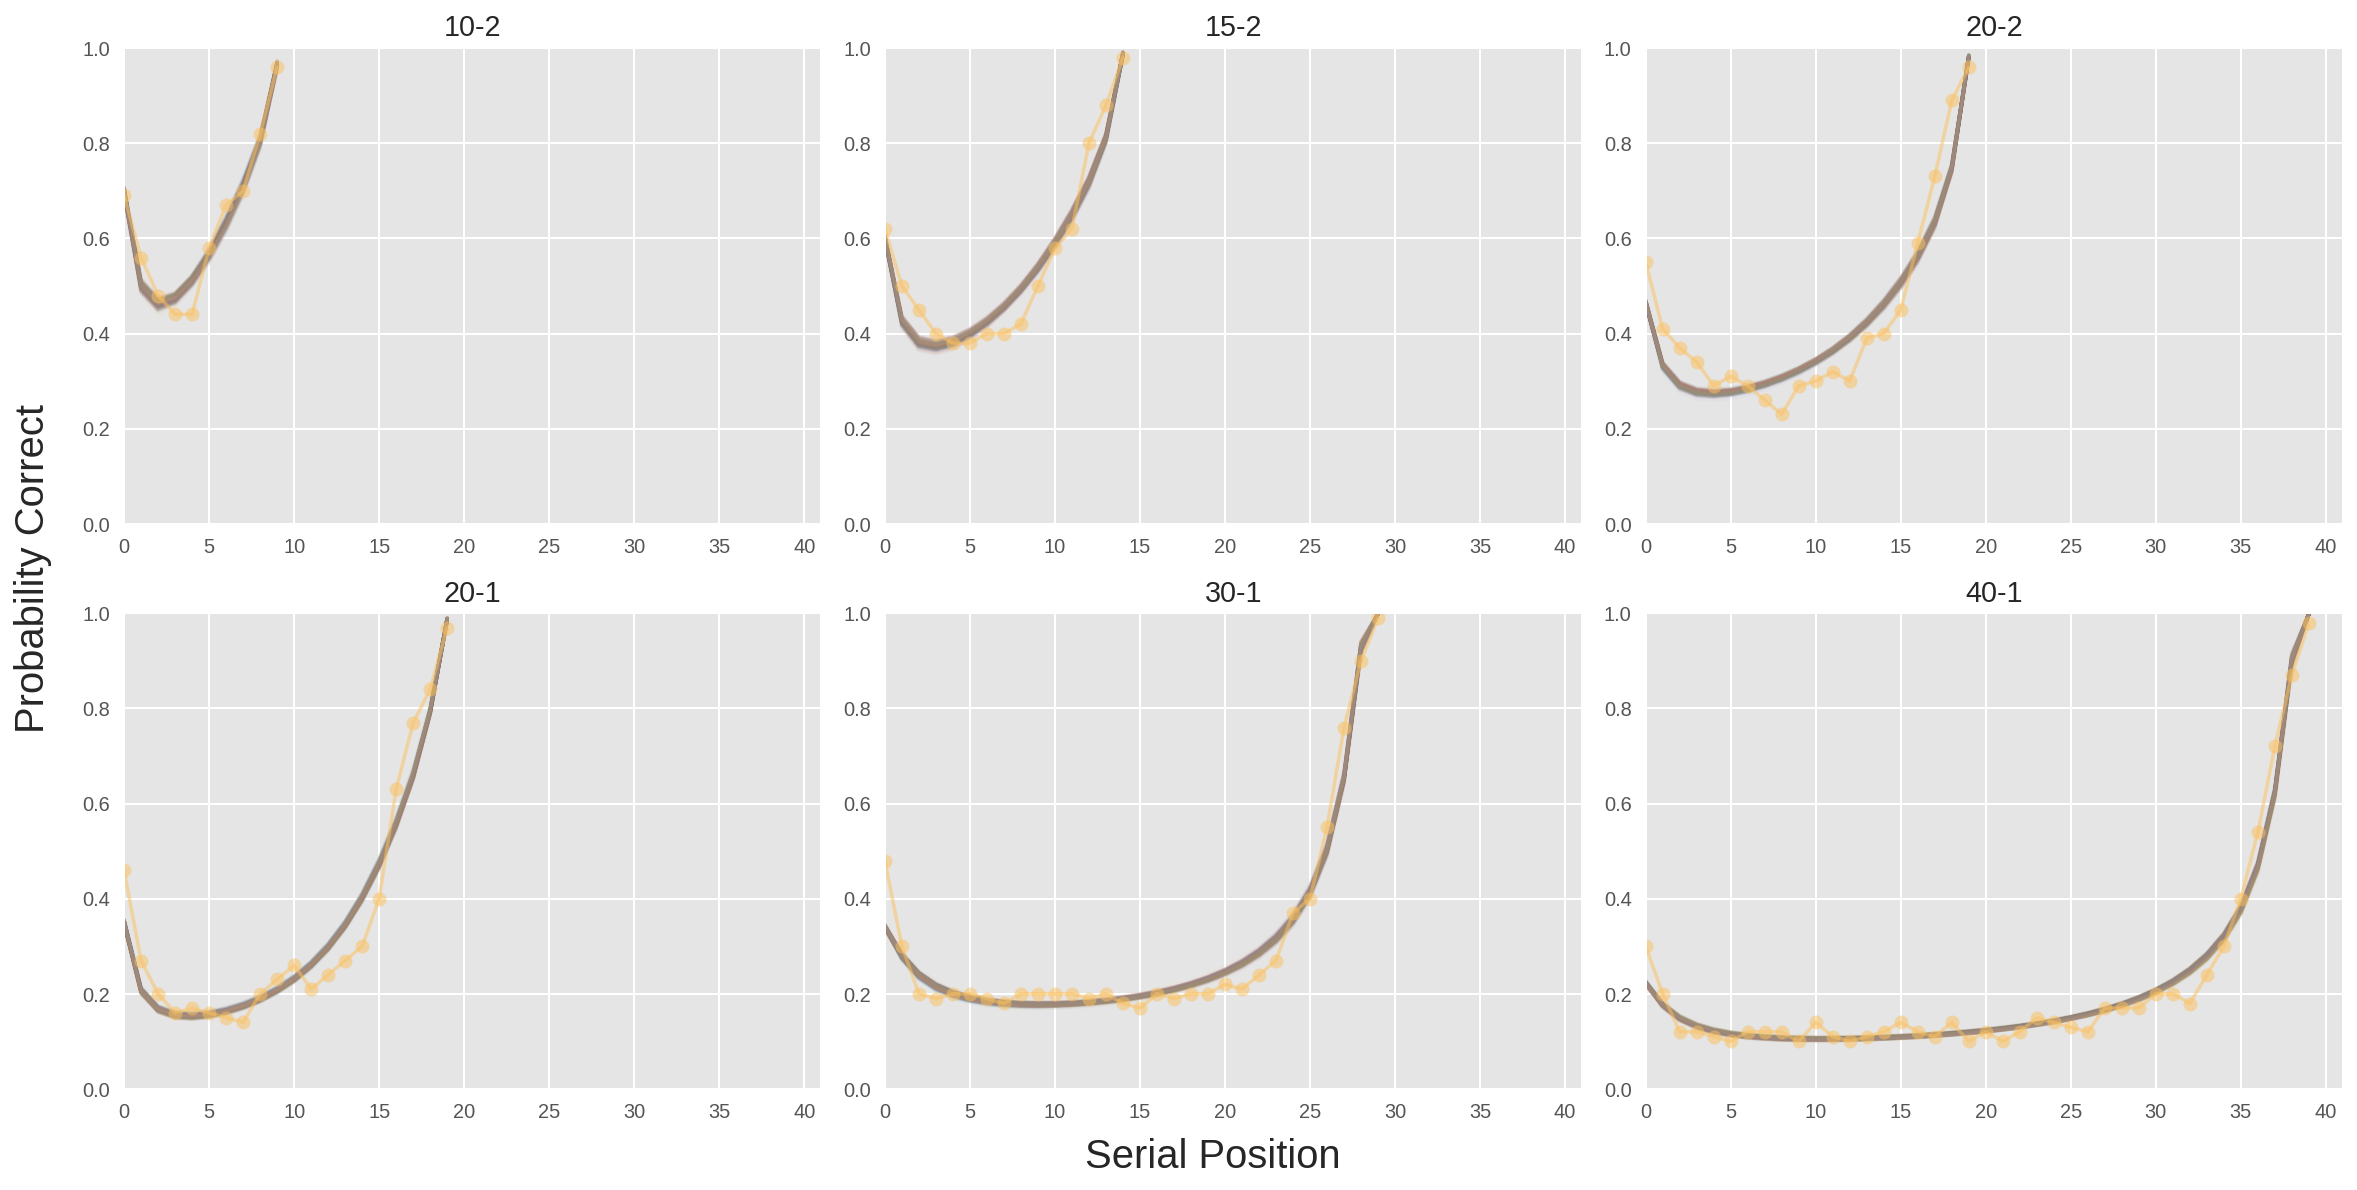

In [5]:
ymat = np.asarray(y).T
mmat = m.T

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Serial Position', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct', va='center', rotation='vertical', fontsize=20)

burnin=1000
totalsamp=3e3
ppcsamples=200

gs = gridspec.GridSpec(2, 3)
for ip in range(dsets):
    ax = plt.subplot(gs[ip])
    ay=ymat[:, ip]/n[ip] # pcmat[:,ip]

    cxt=trace['cx'][:, ip]
    sxt=trace['sx'][:, ip]
    txt=trace['tx'][:, ip]
    
    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip], ]*sz).T
    m2 = np.array([mmat[0:sz, ip], ]*sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):
        
        eta=np.exp(-cxt[ips]*abs(np.log(m1)-np.log(m2)))
        etasum=np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+np.exp(-sxt[ips]*(disc-txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), .999)
        ax.plot(theta, alpha=.05)
    
    ax.plot(ay[ay!=0], marker='o', alpha=.5)
    plt.axis((0, 41, 0, 1))
    plt.title(str(listlength[ip])+'-'+str(lagall[ip]))

plt.tight_layout()
plt.show()

## 15.2 A hierarchical extension of SIMPLE


$$ c \sim \text{Uniform}(0,100)$$
$$ s \sim \text{Uniform}(0,100)$$
$$ a_{1} \sim \text{Uniform}(-1,0) $$
$$ a_{2} \sim \text{Uniform}(0,1) $$
$$ t_x = a_{1}W_x + a_{2} $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 14,771:   6%|▌         | 11269/200000 [00:24<06:55, 453.73it/s]   
Convergence archived at 11300
Interrupted at 11,300 [5%]: Average Loss = 65,437
100%|██████████| 3500/3500.0 [09:41<00:00,  5.33it/s]


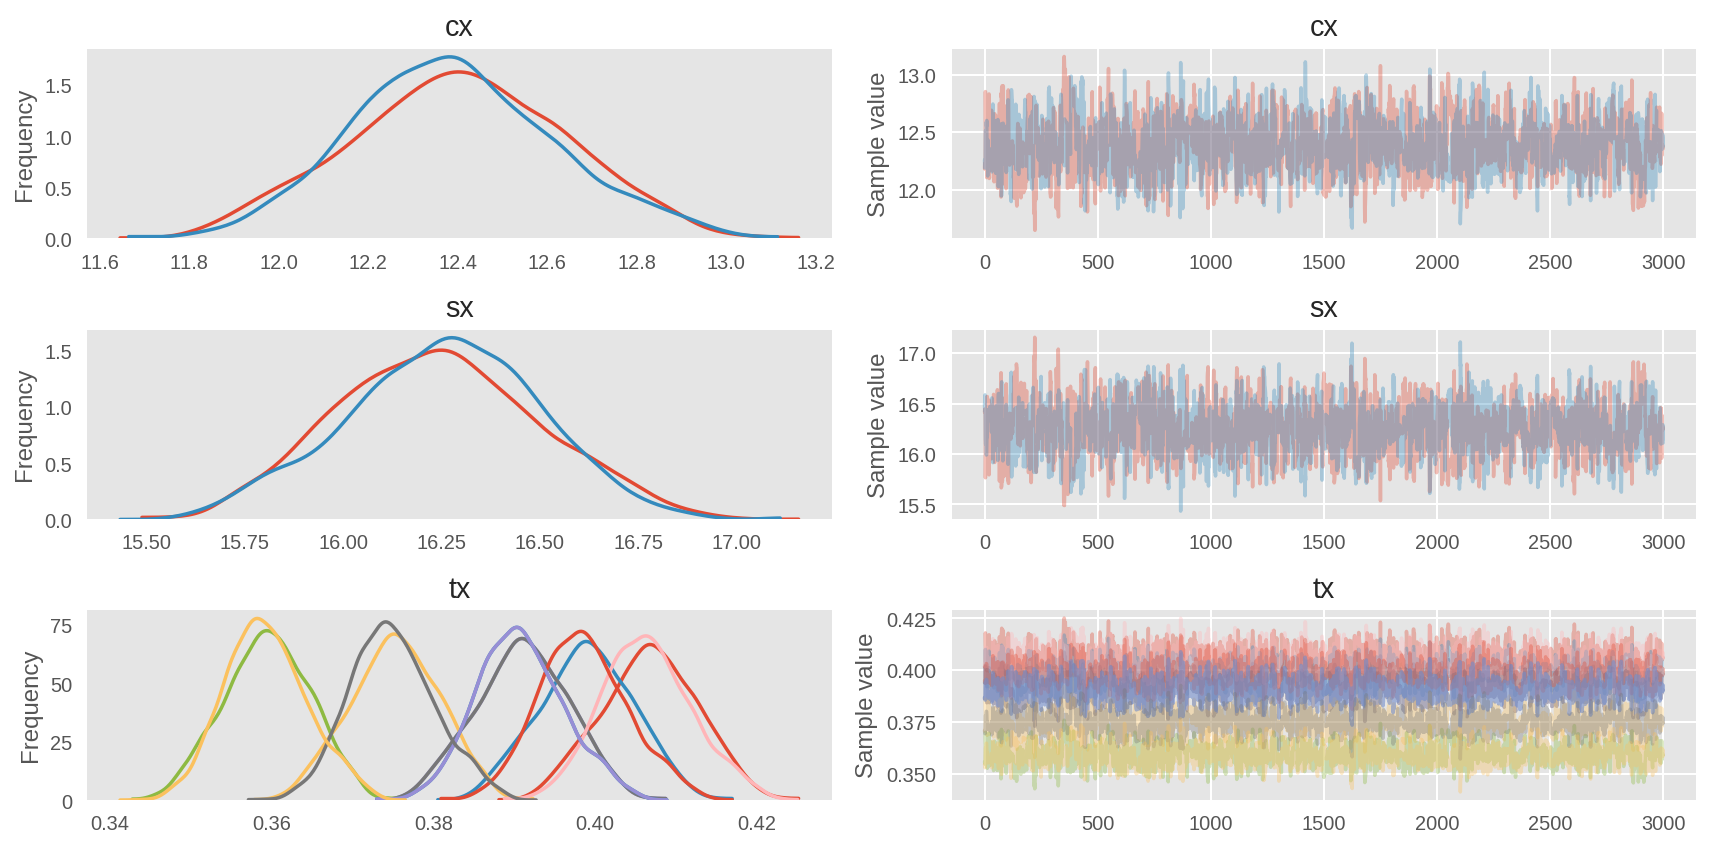

In [6]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2==0] = 1e-5 # to avoid NaN in ADVI
nmat = np.repeat(n[:,np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:,:,np.newaxis],nitem,axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat>0)
W = listlength

with pm.Model() as simple2:
    cx = pm.Uniform('cx', lower=0, upper=100, testval=21)
    sx = pm.Uniform('sx', lower=0, upper=100, testval=10)
    a1 = pm.Uniform('a1', lower=-1, upper=0, testval=-.002)
    a2 = pm.Uniform('a2', lower=0, upper=1, testval=.64)
    tx = pm.Deterministic('tx', a1*W+a2)
    
    # Similarities
    eta = tt.exp(-cx*abs(tt.log(mmat1)-tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2), nitem), (dsets, nitem, nitem))
    
    # Discriminabilities
    disc = eta/etasum
    
    # Response Probabilities
    resp = 1/(1+tt.exp(-sx*(disc-tx[:,np.newaxis,np.newaxis])))
    
    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta=1-tt.prod(1-resp, axis=2)
    
    yobs = pm.Binomial('yobs', p=theta[mask], n=nmat[mask], observed=ymat[mask])
    trace2 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace2, varnames=['cx', 'sx', 'tx']);

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1.1678e+05:   3%|▎         | 5434/200000 [00:05<03:19, 974.05it/s]
Convergence archived at 5500
Interrupted at 5,500 [2%]: Average Loss = 1.9432e+05
100%|██████████| 3500/3500.0 [04:10<00:00, 13.95it/s]


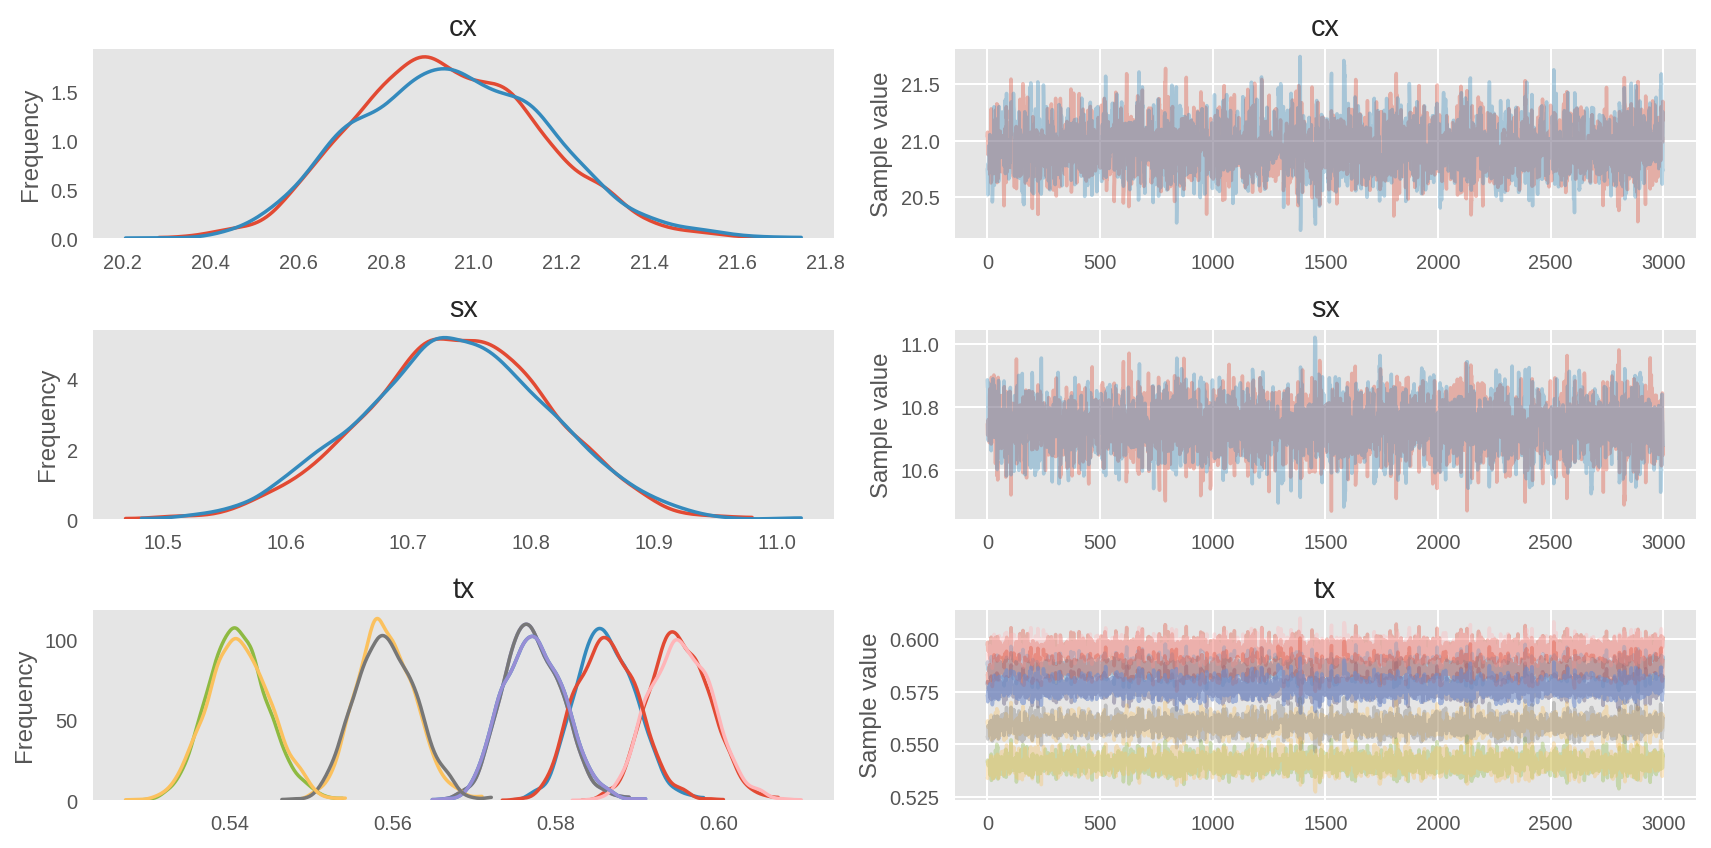

In [7]:
ymat = np.asarray(y).T
mmat = m.T
W = listlength

with pm.Model() as simple2:
    cx = pm.Uniform('cx', lower=0, upper=100, testval=21)
    sx = pm.Uniform('sx', lower=0, upper=100, testval=10)
    a1 = pm.Uniform('a1', lower=-1, upper=0, testval=-.002)
    a2 = pm.Uniform('a2', lower=0, upper=1, testval=.64)
    tx = pm.Deterministic('tx', a1*W+a2)
    
    yobs=[]
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x], ]*sz).T
        m2 = np.array([mmat[0:sz, x], ]*sz)

        eta=tt.exp(-cx*abs(tt.log(m1)-tt.log(m2)))
        etasum=tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+tt.exp(-sx*(disc-tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, .999)
        # theta=1-tt.prod(1-resp,axis=1)
        
        yobs.append([pm.Binomial('yobs_%x'%x, p=theta, n=n[x], observed=ymat[0:sz, x])])
        
    trace2 = pm.sample(3e3, njobs=2)
    
pm.traceplot(trace2, varnames=['cx', 'sx', 'tx']);

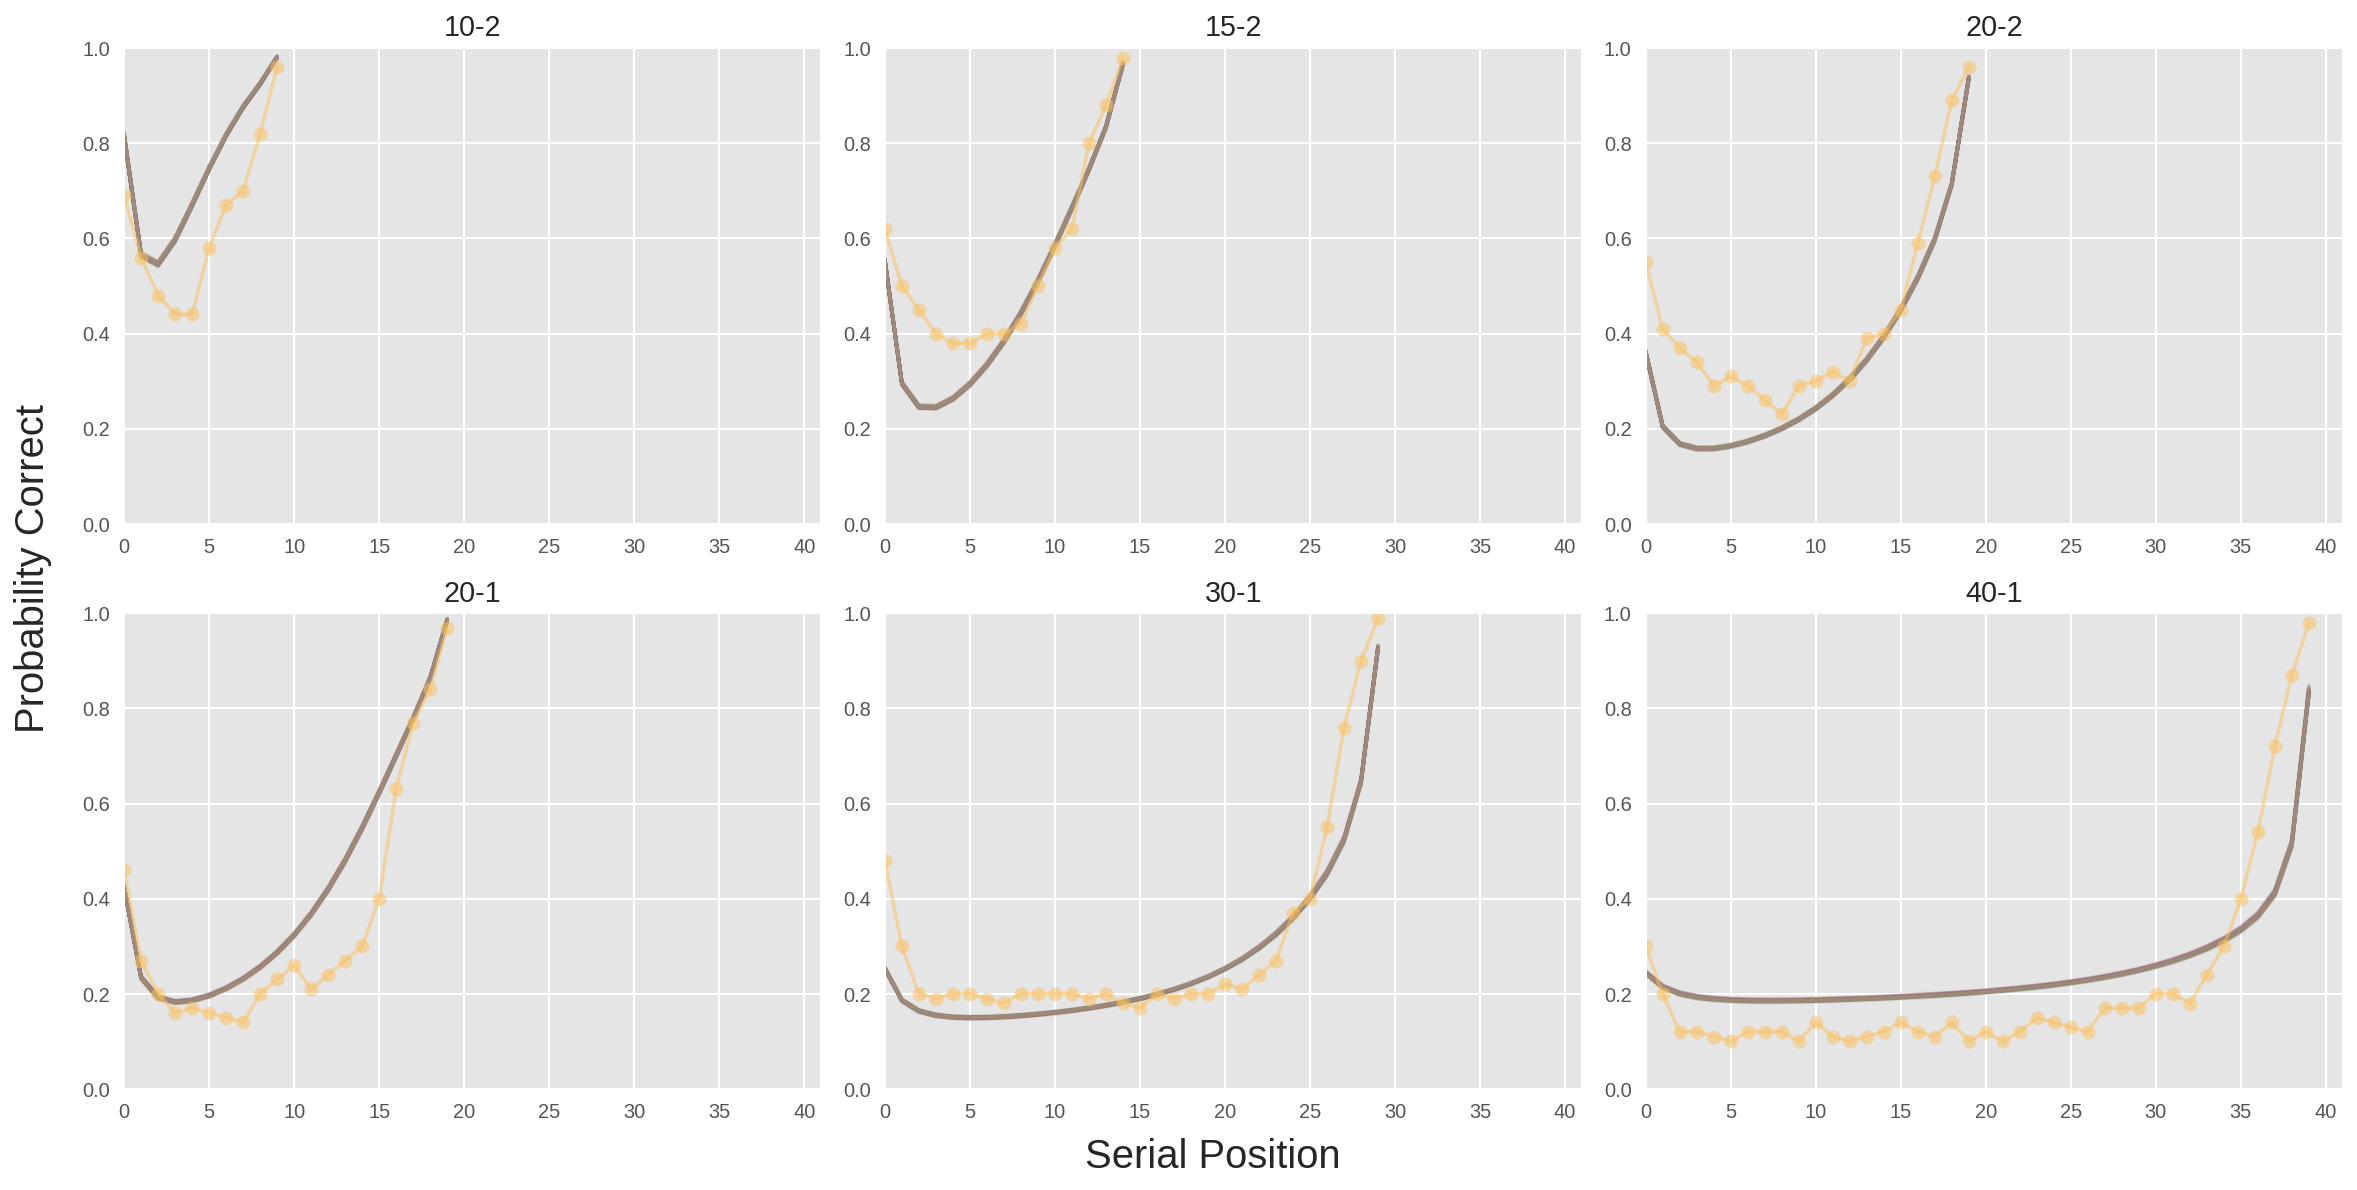

In [8]:
ymat = np.asarray(y).T
mmat = m.T

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Serial Position', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct', va='center', rotation='vertical', fontsize=20)

burnin=1000
totalsamp=3e3
ppcsamples=200

gs = gridspec.GridSpec(2, 3)
for ip in range(dsets):
    ax = plt.subplot(gs[ip])
    ay=ymat[:, ip]/n[ip] # pcmat[:,ip]

    cxt=trace2['cx']
    sxt=trace2['sx']
    txt=trace2['tx'][:, ip]
    
    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip], ]*sz).T
    m2 = np.array([mmat[0:sz, ip], ]*sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):
        
        eta=np.exp(-cxt[ips]*abs(np.log(m1)-np.log(m2)))
        etasum=np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta/etasum
        # Response Probabilities
        resp = 1/(1+np.exp(-sxt[ips]*(disc-txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), .999)
        ax.plot(theta, alpha=.05)
    
    ax.plot(ay[ay!=0], marker='o', alpha=.5)
    plt.axis((0, 41, 0, 1))
    plt.title(str(listlength[ip])+'-'+str(lagall[ip]))

plt.tight_layout()
plt.show()

(18, 24)

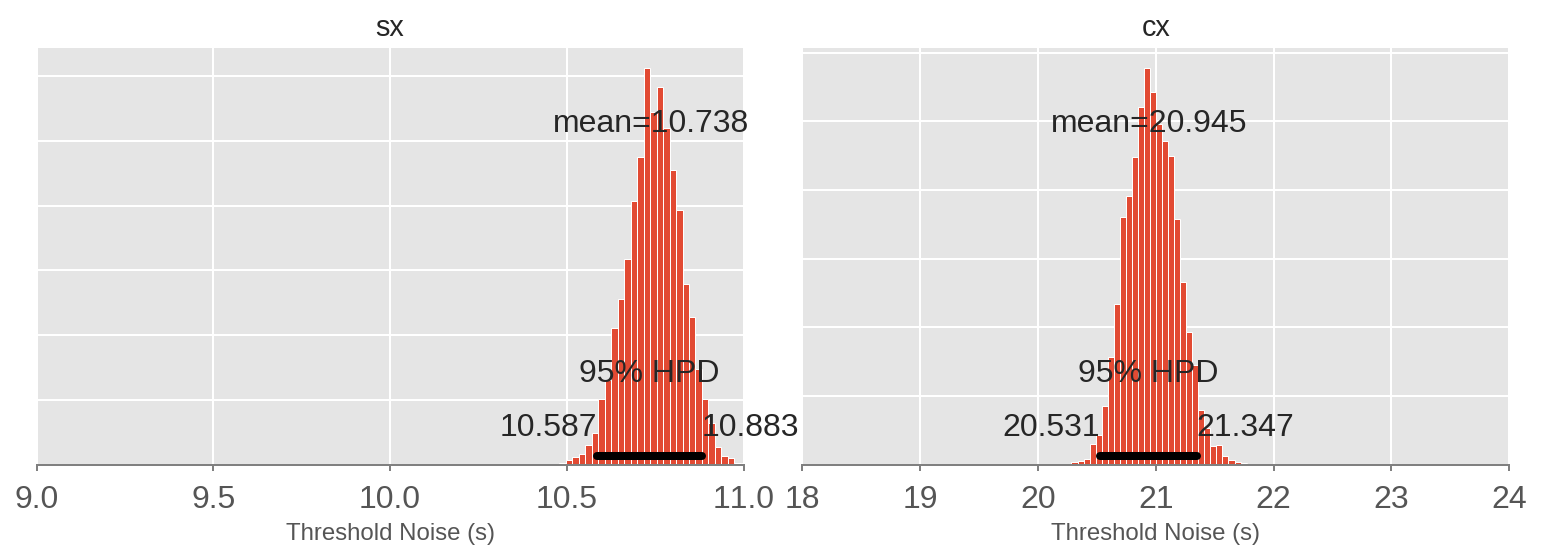

In [9]:
fig = plt.figure(figsize=(16, 4))
ax1=plt.subplot(1,3,1)
pm.plot_posterior(trace=trace2,varnames=['sx'],ax=ax1);
ax1.set_xlabel('Threshold Noise (s)')
ax1.set_xlim([9,11])
ax2=plt.subplot(1,3,2)
pm.plot_posterior(trace=trace2,varnames=['cx'],ax=ax2);
ax2.set_xlabel('Threshold Noise (s)')
ax2.set_xlim([18,24])